In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf

2024-07-04 06:23:42.941934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 06:23:42.967784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 06:23:42.967845: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 06:23:42.984844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 06:23:44.047023: W tensorflow/compiler/tf

In [2]:
# Fetch data from Yahoo Finance
ticker = 'INFY'
start_date = '2010-01-01'
end_date = '2024-06-30'  # Example end date before your forecast period
data = yf.download(ticker, start=start_date, end=end_date)

# Extract adjusted close prices
df = pd.DataFrame(data['Adj Close'])

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Ensure Date is in proper format
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Adj Close'].values.reshape(-1, 1))

# Define the training and test data sizes
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

# Split the data into train and test sets
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:len(scaled_data), :]

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length), 0]
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Choose sequence length (number of time steps to look back)
seq_length = 30  # Example: look back 30 days

# Create sequences for training
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [4]:
model = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    GRU(units=50),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

/home/bhanuj/Desktop/forecast_model/forecastenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0061 - val_loss: 5.2343e-04
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.4889e-04 - val_loss: 9.6379e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.8430e-04 - val_loss: 8.2340e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.6547e-04 - val_loss: 6.5090e-04
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.0700e-04 - val_loss: 4.6456e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.5257e-04 - val_loss: 5.0528e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.6017e-04 - val_loss: 0.0020
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4.4419e-04 - val_loss: 0.0011
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.6516e-04 - val_loss: 0.0019
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.4844e-04 - val_loss: 4.5279e-04
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.3118e-04 - val_loss: 4.

In [5]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


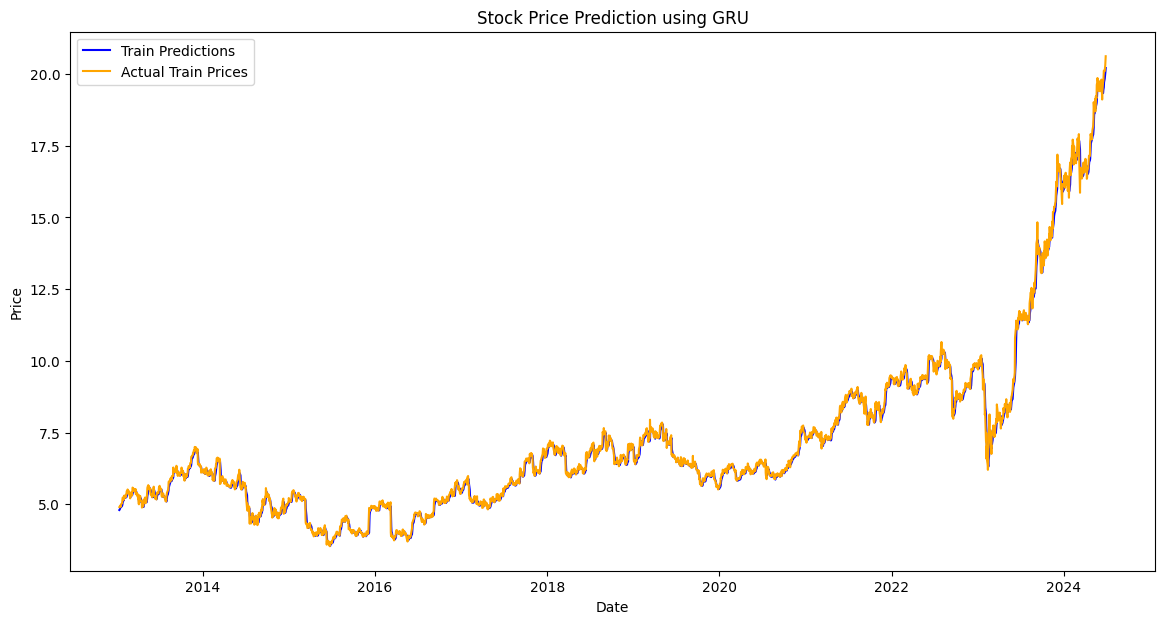

In [6]:
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(df['Date'][-len(train_predict):], train_predict, color='blue', label='Train Predictions')
#plt.plot(df['Date'][-len(test_predict):], test_predict, color='green', label='Test Predictions')
plt.plot(df['Date'][-len(y_train[0]):], y_train[0], color='orange', label='Actual Train Prices')
#plt.plot(df['Date'][-len(y_test[0]):], y_test[0], color='red', label='Actual Test Prices')
plt.title('Stock Price Prediction using GRU')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

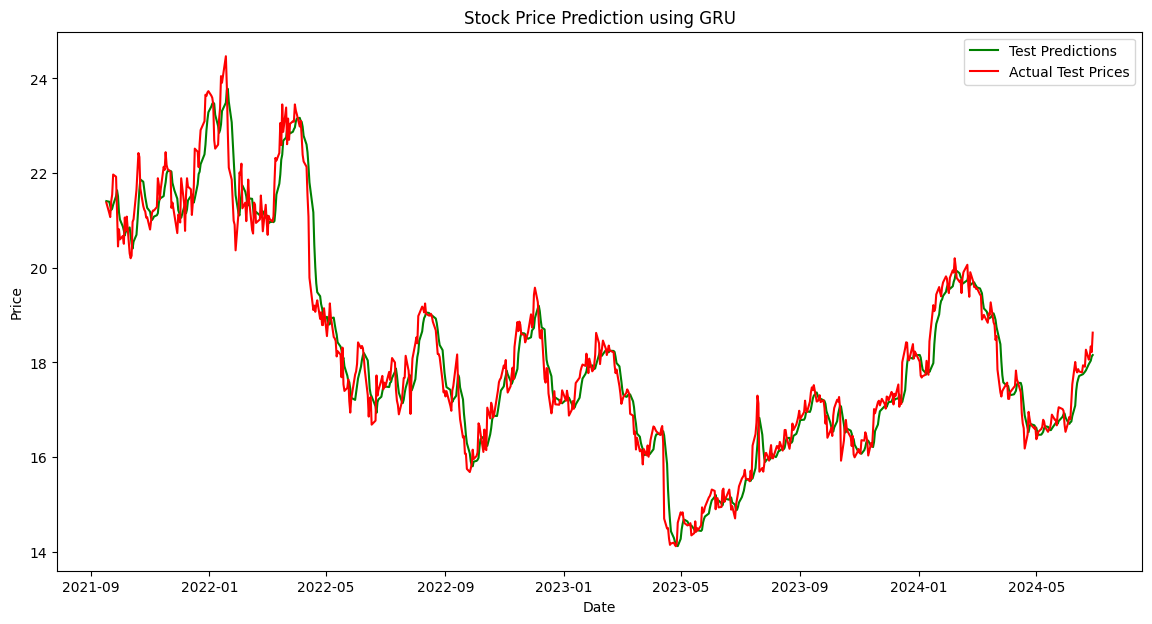

In [7]:
# Visualize the results
plt.figure(figsize=(14, 7))
#plt.plot(df['Date'][-len(train_predict):], train_predict, color='blue', label='Train Predictions')
plt.plot(df['Date'][-len(test_predict):], test_predict, color='green', label='Test Predictions')
#plt.plot(df['Date'][-len(y_train[0]):], y_train[0], color='orange', label='Actual Train Prices')
plt.plot(df['Date'][-len(y_test[0]):], y_test[0], color='red', label='Actual Test Prices')
plt.title('Stock Price Prediction using GRU')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()